# Using snowslide in a classic workflow

Snowslide is a module designed to redistribute snow by simulating avalanches based on an initial snow height situation and a digital terrain model. Two main functions have been implemented :
- snowslide_base
- snowslide_complete

These two functions are identical in terms of simulation, but snowslide_base simply returns the snow height matrix after simulation, whereas snowslide_complete provides the convergence trend and snow heights at each iteration. It also offers the option of displaying results in 2D and 3D for users who want to work specifically on snowslide results. However, these capabilities greatly reduce the computational speed of the algorithm and are not of greater scientific interest for most users. In this notebook we will therefore focus solely on the operation of the snowslide_base function. 

## Step 1 : import snowslide

In [3]:
import numpy as np 
import rasterio
import xarray
import matplotlib.pyplot as plt

import os

In [1]:
import snowslide

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Step 2 : Initialize snowslide

Snowslide requires at least two parameters to work: 
- (1) a path to a .tif file containing the dem (you need to enter a path and not the table directly because snowslide uses the pysheds module).
- (2) An np.array of the same size as the dem giving the initial snow heights. With the current functionality, it's up to the user to decide how they want to initialise this table (ideal data, real data, etc.) and how often they want to trigger avalanches and therefore reset this table. In the future, snowslide should offer methods for initialising snow heights from real data according to user requests... 

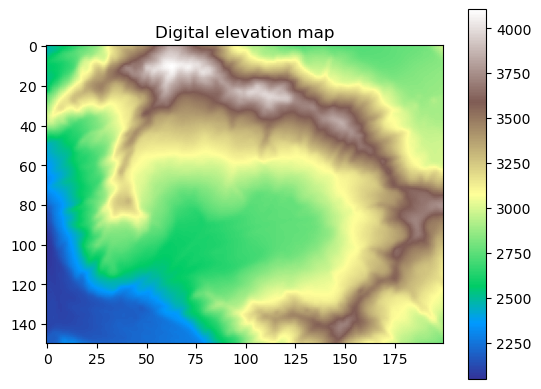

In [7]:
# The user must give the path to the dem file as input 
dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/dem.tif"

# Plotting code
plt.imshow(rasterio.open(dem_path).read(1),cmap='terrain')
plt.title('Digital elevation map')
plt.colorbar()

Then the user must define a matrix of same size as the dem to initialize snowslide. Let's call this matrix SND0 (for initial Snow Depths). For the example let's juste create a matrix that adds 1m of snow anywhere on the dem 

In [11]:
# The user must define a matrix of same size as the dem to initialize the model
shape = np.shape(rasterio.open(dem_path).read(1)) # gets the shape of the dem
snow_init = 1
SND0 = np.full(shape,float(snow_init)) # Initialize the snow depths with 1m over the whole dem

## Step 3 : Launch simulation

In [12]:
SND = snowslide.snowslide_base(dem_path,SND0=SND0)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


Variables have been initialized, launching the simulation...
The algorithm converged in : 104  iterations


Text(0.5, 1.0, 'Snow Depth after avalanches')

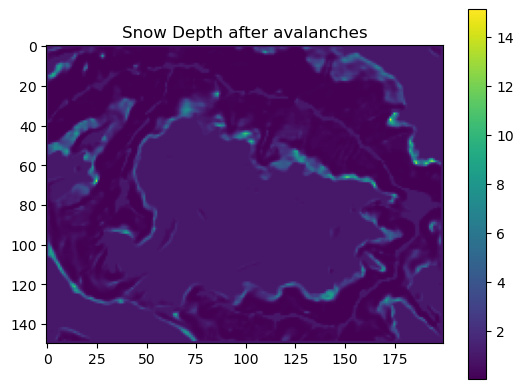

In [10]:
# PLotting code
plt.imshow(SND)
plt.colorbar()
plt.title('Snow Depth after avalanches')

You've launched Snowslide and got the result - well done!

But snowslide also offers the user a little more freedom, particularly in the choice of a number of simulation parameters. Let's take a closer look. 

## Step 4 : closer look into simulation parameters

Snowslide allows you to choose input parameters in the form of dictionaries, booleans or floating numbers : 

    path_dem: str
        Path to the dem file (.tif)
    SND0: numpy.ndarray
        Numpy matrix of the same size as the dem containing the initial snow depths (derived from precipitation). 
    save_path: str
        Path where the user want to save the data produced (.tif file of the SND matrix). Default is None.
        If no path is indicated, no data is stored (only registered as a variable when running the function)
        If a path is indicated the matrix will be saved as 'converged_SND.tif' file
    epsilon: float
        Condition to get out the loop (convergence is considered reached when indicateur < epsilon). Default is 1e-3.
    param_expo: dictionary
        The maximum snow height each pixel can store is computed as an exponential function of the slope. Parameters are the following:
            SND_max=c*exp(a*slope)
        a: float
            Default is -0.14. 
        c: float
            Default is 145
        min: float
            Default is 0.05.
    param_routing: dictionary
        Parameters used by pysheds to realize the routing of the snow. 
        routing: str 
            routing method ('mfd' or 'd8')
        preprocessing: bolean
            activate or deactivate preprocessing of the DEM. Deactivate it affects convergence. 

In [13]:
save_path = None # Inidcating a path to a folder would store the convergence as a .tif file in the store based on the georeferences data of the dem.tif
epsilon = 1e-3 # It affects the condition to consider the algorithm has converged. A more restrictive condition has shown little effect on the result. 
param_expo = {"a":0.14,"c":145,"min":0.05} 
param_routing = {"routing":'mfd',"preprocessing":True}

These parameters can be modified according to the user's wishes. In particular, the parameterisation of the exponential function determining the maximum quantity of snow that can be retained by a pixel with a given slope can be adjusted using the parameters defined in param_expo. One of the most interesting parameters for the user would be to modify the routing method used (d8 or mfd). We recommend the use of preprocessing (variable True) in the majority of cases, but it has been shown to be a source of problems on very regular concave dem's. Nevertheless, in the case of real data, it ensures the convergence of the algorithm towards the correct solution. 

Let's give an example of simulations with different routing parameters :

In [14]:
dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example/dem.tif"
shape = np.shape(rasterio.open(dem_path).read(1))
snow_init = 1
SND0 = np.full(shape,float(snow_init))
param_routing = {"routing":'mfd',"preprocessing":True}

# 'mfd' method routing
SND1 = snowslide.snowslide_base(dem_path,SND0=SND0,param_routing = param_routing)

# 'd8' method routing
param_routing = {"routing":'d8',"preprocessing":True}
SND2 = snowslide.snowslide_base(dem_path,SND0=SND0,param_routing = param_routing)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


Variables have been initialized, launching the simulation...
The algorithm converged in : 104  iterations
Variables have been initialized, launching the simulation...


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


The algorithm converged in : 75  iterations


Text(0.5, 1.0, 'Snow Depth after d8 avalanches')

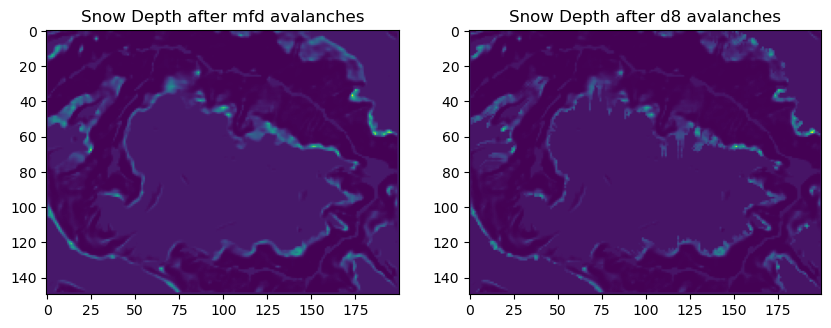

In [15]:
# Plotting code 
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(SND1)
ax[0].set_title('Snow Depth after mfd avalanches')
ax[1].imshow(SND2)
ax[1].set_title('Snow Depth after d8 avalanches')

## Step 5 : Use inside functions 

The snowslide package also allows you to call the functions that build body of the simulation and that are described in the readme. These functions can be found in the ``snowslide/functions.py`` file.
As an example you can calculate the slope of a DEM very easily. 

In [16]:
from snowslide.functions import *

dem = rasterio.open(dem_path).read(1) # Open DEM as an equivalent of an np array
resolution =  rasterio.open(dem_path).res

dem_slope = slope(dem,resolution[0],resolution[1])

Text(0.5, 1.0, 'Slope in °')

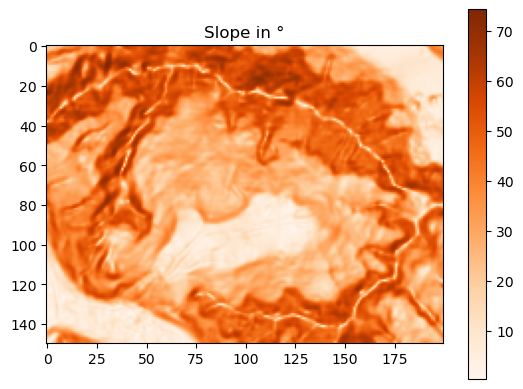

In [18]:
# Plotting code 
plt.imshow(dem_slope,cmap='Oranges')
plt.colorbar()
plt.title('Slope in °')

More informations about each of these functions will be updated later in the ReadMe. 